# Loan Sanctioning Use Case

In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import datawig

import seaborn as sns
import scipy.stats as sts
import matplotlib.pyplot as plt
%matplotlib inline

# Importing necessary libraries

In [9]:
training_data = pd.read_csv('cipla/train.csv')
# Loading the training data into a pandas dataframe

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
training_data.head(10)
# Viewing data sample

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-36995,Frederica Shealy,F,56,1933.05,Low,Working,Sales staff,Semi-Urban,72809.58,241.08,N,N,3.0,809.44,0,NaN,746,1933.05,4,Rural,1,119933.46,54607.18
1,C-33999,America Calderone,M,32,4952.91,Low,Working,NaN,Semi-Urban,46837.47,495.81,N,Y,1.0,780.40,0,Unpossessed,608,4952.91,2,Rural,1,54791.00,37469.98
2,C-3770,Rosetta Verne,F,65,988.19,High,Pensioner,NaN,Semi-Urban,45593.04,171.95,N,Y,1.0,833.15,0,Unpossessed,546,988.19,2,Urban,0,72440.58,36474.43
3,C-26480,Zoe Chitty,F,65,NaN,High,Pensioner,NaN,Rural,80057.92,298.54,N,Y,2.0,832.70,1,Unpossessed,890,NaN,2,Semi-Urban,1,121441.51,56040.54
4,C-23459,Afton Venema,F,31,2614.77,Low,Working,High skill tech staff,Semi-Urban,113858.89,491.41,N,Y,NaN,745.55,1,Active,715,2614.77,4,Semi-Urban,1,208567.91,74008.28
5,C-17688,Polly Crumpler,F,60,1234.92,Low,State servant,Secretaries,Rural,34434.72,181.48,N,N,2.0,684.12,1,Inactive,491,1234.92,2,Rural,1,43146.82,22382.57
6,C-23855,Nathalie Olivier,M,43,2361.56,Low,Working,Laborers,Semi-Urban,152561.34,697.67,Y,Y,2.0,637.29,0,Unpossessed,227,2361.56,1,Semi-Urban,1,221050.80,0.00
7,C-11006,Clarinda Montana,F,45,NaN,Low,State servant,Managers,Semi-Urban,240311.77,807.64,N,N,2.0,812.26,0,Active,314,NaN,2,Urban,1,401040.70,168218.24
8,C-26934,Kenny Ankrom,F,38,1296.07,Low,Working,Cooking staff,Rural,35141.99,155.95,N,Y,3.0,705.29,1,Active,241,1296.07,4,Rural,1,54903.44,22842.29
9,C-24944,Barbie Goetsch,M,18,1546.17,Low,Working,Laborers,Rural,42091.29,500.20,N,N,2.0,613.24,0,Unpossessed,883,1546.17,2,Urban,1,67993.43,0.00


In [18]:
training_data.shape
# data size (number of rows and coloumns)

(30000, 24)

In [5]:
training_data.info()
# data type and non-null values for each coloumn

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
Customer ID                    30000 non-null object
Name                           30000 non-null object
Gender                         29947 non-null object
Age                            30000 non-null int64
Income (USD)                   25424 non-null float64
Income Stability               28317 non-null object
Profession                     30000 non-null object
Type of Employment             22730 non-null object
Location                       30000 non-null object
Loan Amount Request (USD)      30000 non-null float64
Current Loan Expenses (USD)    29828 non-null float64
Expense Type 1                 30000 non-null object
Expense Type 2                 30000 non-null object
Dependents                     27507 non-null float64
Credit Score                   28297 non-null float64
No. of Defaults                30000 non-null int64
Has Active Credit Card         28434 non

In [6]:
print(training_data.isnull().values.any())
print(training_data.isnull().sum())

# Listing out the number of missing values in each coloumn
# Note all the missing values which must be dealt with before be begin training our model 

True
Customer ID                       0
Name                              0
Gender                           53
Age                               0
Income (USD)                   4576
Income Stability               1683
Profession                        0
Type of Employment             7270
Location                          0
Loan Amount Request (USD)         0
Current Loan Expenses (USD)     172
Expense Type 1                    0
Expense Type 2                    0
Dependents                     2493
Credit Score                   1703
No. of Defaults                   0
Has Active Credit Card         1566
Property ID                       0
Property Age                   4850
Property Type                     0
Property Location               356
Co-Applicant                      0
Property Price                    0
Loan Sanction Amount (USD)      340
dtype: int64


In [7]:
training_data.describe()

# 5-pt description of all the numerical columns
# Note the min value in Current Loan Expenses, Co-Applicant, Property Price & Loan Sanction Amount (USD).
# Its negetive, which makes no logical sense. These entries need to be analysed and fixed.
# Looking at the max value, we can spot some outliers. They must be removed.

,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property ID,Property Age,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD)
count,30000.000000,2.542400e+04,30000.000000,29828.000000,27507.000000,28297.000000,30000.000000,30000.000000,2.515000e+04,30000.000000,30000.000000,3.000000e+04,29660.000000
mean,40.092300,2.630574e+03,88826.333855,400.936876,2.253027,739.885381,0.193933,501.934700,2.631119e+03,2.460067,-4.743867,1.317597e+05,47649.342208
std,16.045129,1.126272e+04,59536.949605,242.545375,0.951162,72.163846,0.395384,288.158086,1.132268e+04,1.118562,74.614593,9.354955e+04,48221.146686
min,18.000000,3.777000e+02,6048.240000,-999.000000,1.000000,580.000000,0.000000,1.000000,3.777000e+02,1.000000,-999.000000,-9.990000e+02,-999.000000
25%,25.000000,1.650457e+03,41177.755000,247.667500,2.000000,681.880000,0.000000,251.000000,1.650450e+03,1.000000,1.000000,6.057216e+04,0.000000
50%,40.000000,2.222435e+03,75128.075000,375.205000,2.000000,739.820000,0.000000,504.000000,2.223250e+03,2.000000,1.000000,1.099936e+05,35209.395000
75%,55.000000,3.090593e+03,119964.605000,521.292500,3.000000,799.120000,0.000000,751.000000,3.091407e+03,3.000000,1.000000,1.788807e+05,74261.250000
max,65.000000,1.777460e+06,621497.820000,3840.880000,14.000000,896.260000,1.000000,999.000000,1.777460e+06,4.000000,1.000000,1.077967e+06,481907.320000


In [8]:
# Plot the frequency distribution of each coloumn to check for inconsistencies. 
# This was done by me to find inconsistencies but will not be shown in the submission file, to save space. 
# If Interested remove # and run this block.

# sns.distplot(training_data["Age"])
# sns.distplot(training_data["Income (USD)"])
# sns.distplot(training_data["Loan Amount Request (USD)"])
# sns.distplot(training_data["Current Loan Expenses (USD)"])
# sns.distplot(training_data["Credit Score (USD)"])
# sns.distplot(training_data["Property Price"])
# sns.distplot(training_data["Loan Sanction Amount (USD)"])

# sns.countplot(training_data['Gender'])
# sns.countplot(training_data['Income Stability'])
# sns.countplot(training_data['Location'])
# sns.countplot(training_data['Expense Type 1'])
# sns.countplot(training_data['Expense Type 2'])
# sns.countplot(training_data['No. of Defaults'])
# sns.countplot(training_data['Dependents'])
# sns.countplot(training_data['Has Active Credit Card'])
# sns.countplot(training_data['Co-Applicant'])

# print (training_data['Profession'].value_counts())
# print (training_data['Type of Employment'].value_counts())
# print (training_data['Property Type'].value_counts())

# sns.pairplot(training_data)

# Plots of current loan expenses, co-applcant, property price & loan sanction amount shows presence of -999 values.
# Outliers are seen when plotting dependents and loan sanction amounts.
# Looking at the value counts of profession shows us that several categories have only only 1 or 2 entries in the data  and can be removed.
# All this, along with the null values are handeled during pre-processing a few cells below.

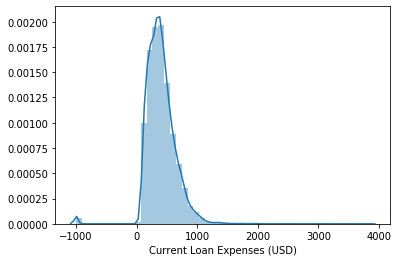

In [12]:
sns.distplot(training_data["Current Loan Expenses (USD)"])

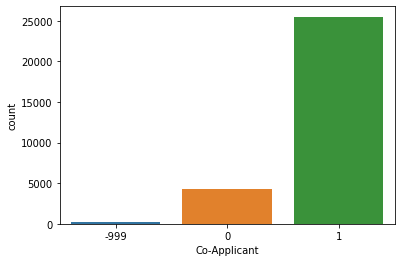

In [13]:
sns.countplot(training_data['Co-Applicant'])

In [14]:
print (training_data['Profession'].value_counts())

Working                 16926
Commercial associate     7962
Pensioner                2740
State servant            2366
Unemployed                  2
Businessman                 2
Maternity leave             1
Student                     1
Name: Profession, dtype: int64


In [15]:
print (training_data['Dependents'].value_counts())

2.0     13108
3.0      5719
1.0      5544
4.0      2704
5.0       372
6.0        50
7.0         7
10.0        1
14.0        1
8.0         1
Name: Dependents, dtype: int64


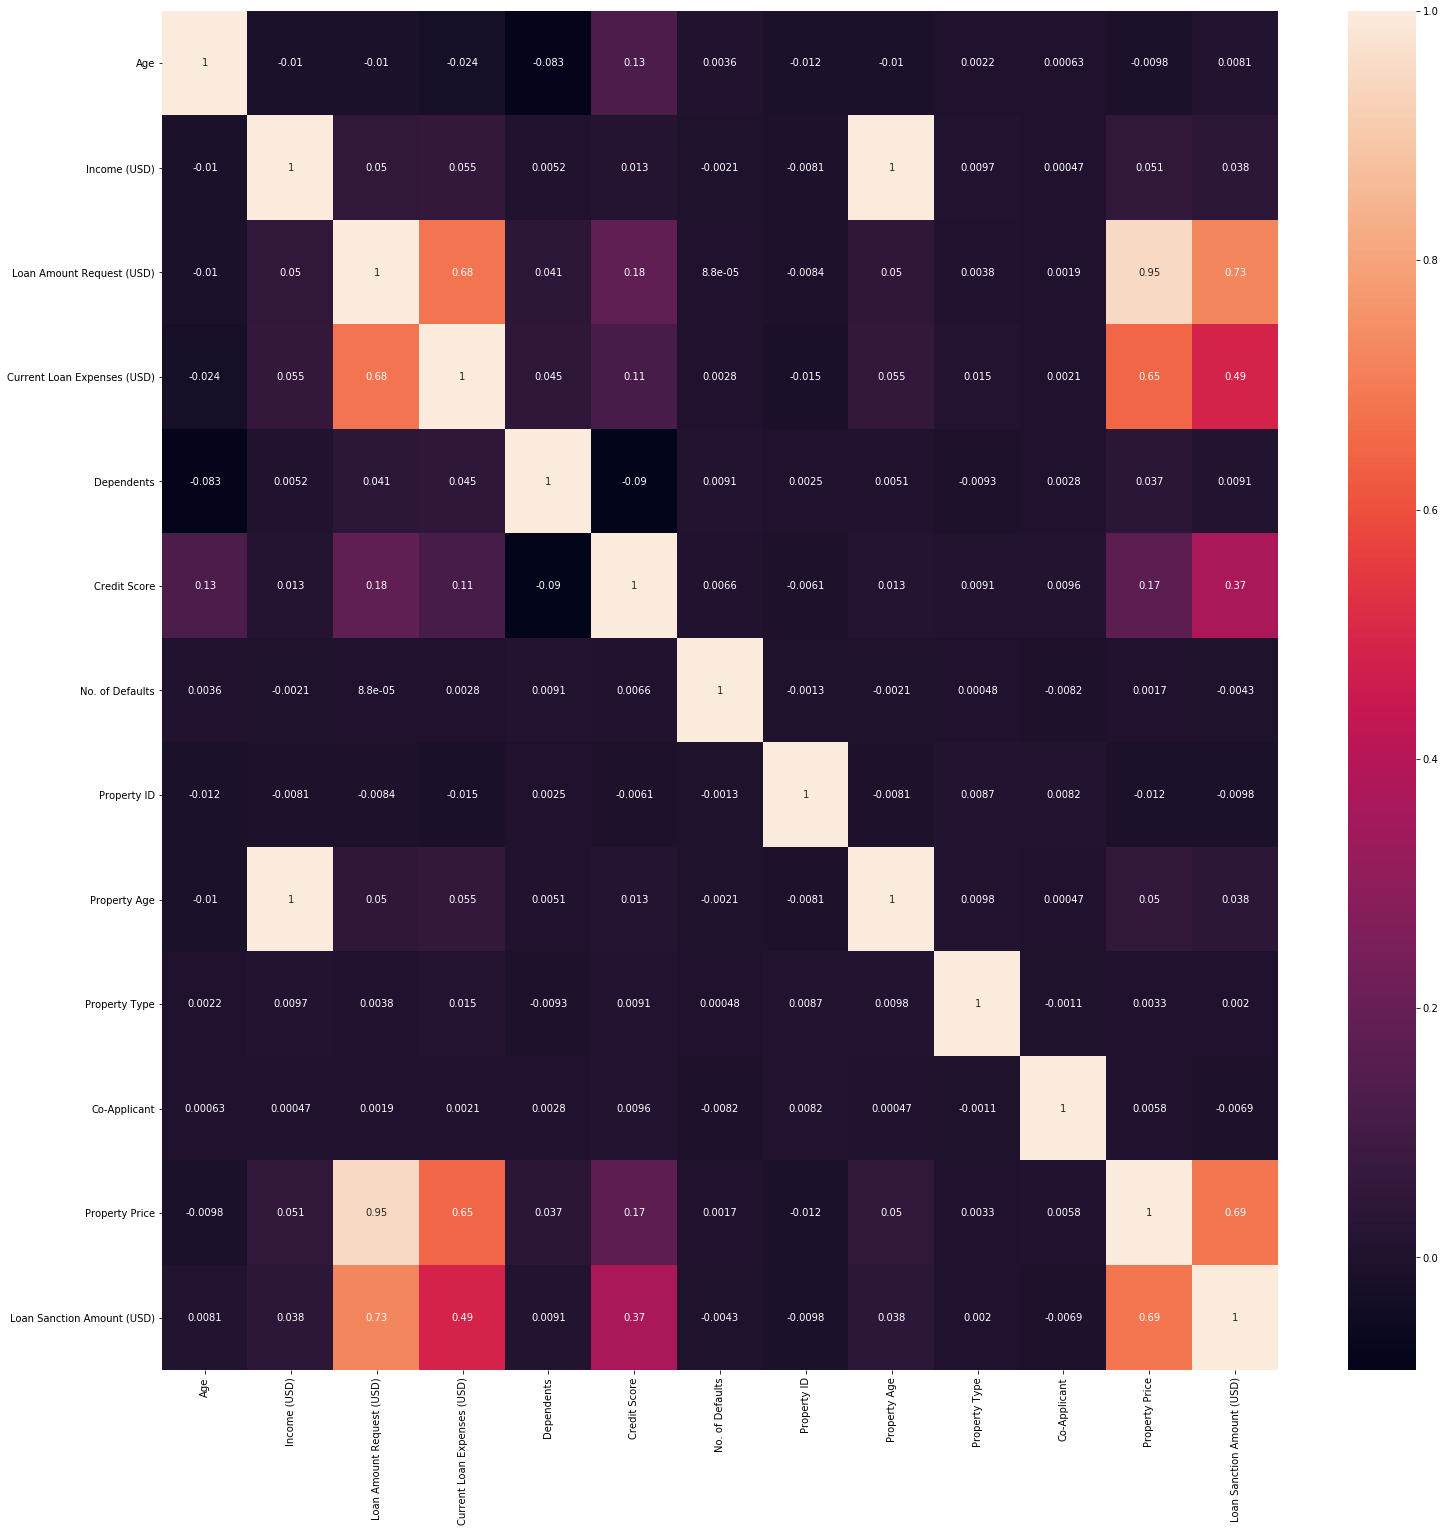

In [9]:
training_data.corr()
plt.figure(figsize = (25,25))
sns.heatmap(training_data.corr(), annot=True)

# Plotting the Correlation matrix to see which indepentent varible most affect our dependent variable.
# The most significant independent variables are Income, Loan Amount Request, Current Loan Expenses, Credit Score & Property Price.

# Also note that income and property age have a correlation of one. Examining these two coloumns in the databse, we notice that
#the 2 coloumns are identical. This is obviously an error and hence we will be dropping the latter coloumn.

In [10]:
training_data.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

# The above correlation matrix only applies to numerical datatypes. Hence we will build our own to look at the correlation with
# the categorical data.

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
Customer ID,1.000000,1.000000,0.008870,-0.002994,0.735633,0.002337,0.002761,-0.003832,0.003182,0.999433,0.799775,-0.003157,-0.008145,-0.001820,0.592016,-0.011539,0.007341,0.051483,0.727816,-0.000681,0.004146,0.009129,0.976525,0.624826
Name,1.000000,1.000000,0.008870,-0.002994,0.735633,0.002337,0.002761,-0.003832,0.003182,0.999433,0.799775,-0.003157,-0.008145,-0.001820,0.592016,-0.011539,0.007341,0.051483,0.727816,-0.000681,0.004146,0.009129,0.976525,0.624826
Gender,0.008870,0.008870,1.000000,0.002999,0.008972,0.006264,0.002787,-0.006806,-0.001293,0.008751,0.003312,-0.000276,0.002681,-0.000673,0.005931,0.000167,-0.002519,0.003301,0.008780,-0.003092,0.000931,-0.004915,0.006544,0.002244
Age,-0.002994,-0.002994,0.002999,1.000000,0.003268,-0.191081,-0.000360,0.087884,0.003777,-0.003038,-0.001633,0.028999,-0.017867,-0.021572,0.002402,-0.005731,-0.001186,-0.002357,0.003930,0.006019,-0.001085,-0.055349,-0.002636,-0.023832
Income (USD),0.735633,0.735633,0.008972,0.003268,1.000000,0.024658,0.003302,0.003879,-0.004655,0.735617,0.591649,-0.003822,-0.008954,0.031445,0.456042,-0.009218,0.005300,0.041056,0.986494,0.005850,0.002568,0.049657,0.721184,0.401093
Income Stability,0.002337,0.002337,0.006264,-0.191081,0.024658,1.000000,-0.008971,-0.236242,-0.008746,0.002528,0.000611,-0.069516,0.037306,0.044140,0.009837,0.003541,-0.002130,0.007171,0.023991,-0.008494,0.009450,0.185658,0.006990,0.012004
Profession,0.002761,0.002761,0.002787,-0.000360,0.003302,-0.008971,1.000000,-0.005364,0.145963,0.002784,0.010910,0.015540,-0.000979,0.004736,0.003585,-0.005651,-0.040908,-0.004833,0.003907,0.003841,-0.003021,-0.012351,0.003135,0.027176
Type of Employment,-0.003832,-0.003832,-0.006806,0.087884,0.003879,-0.236242,-0.005364,1.000000,0.012176,-0.003999,-0.000857,0.041877,-0.008296,-0.010432,-0.001950,0.005408,-0.004376,-0.003637,0.003514,-0.000491,0.002898,-0.068688,-0.005112,-0.017250
Location,0.003182,0.003182,-0.001293,0.003777,-0.004655,-0.008746,0.145963,0.012176,1.000000,0.003202,0.007611,0.009539,-0.008737,-0.001626,0.000996,0.008204,-0.007902,-0.008761,-0.005996,0.001112,0.001275,-0.007282,-0.000684,0.012549
Loan Amount Request (USD),0.999433,0.999433,0.008751,-0.003038,0.735617,0.002528,0.002784,-0.003999,0.003202,1.000000,0.799549,-0.003153,-0.008123,-0.001957,0.591620,-0.011266,0.007252,0.051474,0.727723,-0.000506,0.004217,0.009181,0.975951,0.624742


In [11]:
# Here, we look at the outliers present in the different columns and list them out.
# Note: we use 3 times the standard deviation as the upper and lower limit due to the large number of outliers that are
# present when we use 2*std. This will be covering 99% of the data. We only have a few outliers, which we can replace with
# the upper/lower limits or drop. We will be doing the latter in the pre-processing section below.

# In general outliers are mistakes in the data or rare occurences which do not help with model building. In this case
# the outliers lie in only 2-3 coloumns (Profession, Dependents & Loan Sanction Amount). But looking at these values 
# they are belivable values from what we know about the database. Due to this and since most of these values are within 
# what we know an acceptable range we will not be atlering them bar a few extrems.

# for j in colm:
#    colm_name = j
#    outliers=[]
#    data = training_data[j]
#    mean=data.mean()
#    standard_deviation=data.std()
#    cutoff=standard_deviation*3
#    lower_limit=mean-cutoff
#    upper_limit=mean+cutoff
#
#    for i in data:
#        if (i > upper_limit or i < lower_limit):
#            outliers.append(i)
#    count = count + len(outliers)
#    print(colm_name)
#    print('The Upper and Lower Limits are:')
#    print(upper_limit, lower_limit)
#    print('The Outliers in the Data are:')
#    print(outliers)
# print ("The total number of Outliers are")
# print(count)

# For the remaining variables the number of outliers are very low and these values are already very close to the cutoff
# limits, so we can either replace them with the limits or ignore them as they will not have much impact. We will choose 
# to do the latter. (Although if needed the code below can be used to replace outliers with limits)

# for j in colm:
#     colm_name = j
#     outliers=[]
#     data = training_data[j]
#     mean=data.mean()
#     standard_deviation=data.std()
#     cutoff=standard_deviation*3
#     lower_limit=mean-cutoff
#     upper_limit=mean+cutoff
    
#     x[j] = np.where(x[j] > upper_limit , upper_limit , x[j])
#     x[j] = np.where(x[j] < lower_limit , lower_limit , x[j])
    
#  Replaacing the outliers with their respective upper/lower limits.

In [16]:
temp = training_data[(training_data['Profession'] == 'Businessman') | (training_data['Profession'] == 'Unemployed') | (training_data['Profession'] == 'Maternity leave') | (training_data['Profession'] == 'Student')].index
training_data.drop(temp, inplace = True)
# Drop rows with categories which have only 1 or 2 entries.

temp = training_data[(training_data['Dependents'] > 7)].index
training_data.drop(temp, inplace = True)
# Droping outliers from dependents

training_data['Co-Applicant'].replace(to_replace = -999.000000, value =1, inplace=True)
training_data['Current Loan Expenses (USD)'].replace(to_replace = -999.000000, value = training_data['Current Loan Expenses (USD)'].median(), inplace=True)
# Replace negetive values

training_data.drop(training_data[training_data['Property Price'] < 0].index, axis = 0, inplace = True)
training_data.drop(training_data[training_data['Loan Sanction Amount (USD)'] < 0].index, axis = 0, inplace = True)
training_data.drop(training_data[training_data['Income (USD)'] > 60000].index, axis = 0, inplace = True)
# Replace negative values and remove outliers

training_data.dropna(subset=['Loan Sanction Amount (USD)'], axis = 0, inplace = True)
training_data.dropna(subset=['Credit Score'], axis = 0, inplace = True)
training_data.dropna(subset=['Income (USD)'], axis = 0, inplace = True)

# Dropping rows with null values in the above 3 coloumns (These variables are important for our classification and its better
#to drop the rows with missing values rather than replace them with estimates, so as not to skew the data. 
#Especially since the number of rows with missing values in these coloumns is significant.)

In [8]:
training_data['temp'] = np.where(training_data['Profession']== 'Pensioner', 'High', 'Low')
training_data['Income Stability'].fillna(training_data['temp'], inplace=True)
# Use Profession to fill missing data in Income Stability, since there is a correlation there.

training_data['Current Loan Expenses (USD)'].fillna(training_data['Current Loan Expenses (USD)'].median(), inplace=True)
training_data['Dependents'].fillna(training_data['Dependents'].median(), inplace=True)
# Replace missing values with median

training_data.drop(['Name','Gender','Age','Income Stability','Profession','Type of Employment','Property Age','Location','Expense Type 1','Expense Type 2','Dependents','No. of Defaults','Has Active Credit Card','Property ID','Property Type','Property Location','temp'], axis = 1, inplace=True)# Drop coloumns that have no bearing on the dependent variable

In [30]:
print(training_data.isnull().values.any())
print(training_data.isnull().sum())

training_data.shape

# No more missing values. Outliers eliminated and negative values corrected.

False
Customer ID                    0
Income (USD)                   0
Loan Amount Request (USD)      0
Current Loan Expenses (USD)    0
Credit Score                   0
Co-Applicant                   0
Property Price                 0
Loan Sanction Amount (USD)     0
dtype: int64


(23470, 8)

In [31]:
training_data['Customer ID'] = training_data['Customer ID'].str.replace(r'\D', '').astype(int)

#for i in training_data.columns:
#    if training_data[i].dtype == 'object': 
#        training_data[i] = pd.Categorical(training_data[i])
        
#replaceStruct = {
#                "Income Stability": {"Low": 0, "High": 1},
#                "Expense Type 1":  {"N": 0, "Y": 1},
#                "Expense Type 2":  {"N": 0, "Y": 1},
#                "Location": {"Rural": 0, "Semi-Urban": 1, "Urban":2},
#                }
#oneHotCols=["Profession"]

#training_data=training_data.replace(replaceStruct)
#training_data=pd.get_dummies(training_data, columns=oneHotCols)
#training_data.head(10)

# Here we prepare our data by converting the categorical variables to numerical variables by encoding them
#(Necessary for regression models).
# We perform binary encoding (one hot column) to the variables which have no hierarchy,
# while the others are encoded with integer values.

In [32]:
import numpy as np
import pandas as pd
from sklearn import metrics
import seaborn as sns
import scipy.stats as sts
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import  BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import zscore
from sklearn import metrics
from os import system
# Import libraries needed for model building.

In [33]:
unscaled_x = training_data.drop(['Loan Sanction Amount (USD)'],axis=1)
y = training_data[['Loan Sanction Amount (USD)']]
# Seprating the dependent and independent variables

# Performing normalization so that all the coloumns are equally weighted

# temp = unscaled_x[['Customer ID']]
# unscaled_x.drop(['Customer ID'], axis=1, inplace=True)
x=unscaled_x.apply(zscore)
# x.insert(0, 'Customer ID', temp)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)

# Splitting the data into training and test set in the ratio of 75:25 respectively

In [34]:
model = LinearRegression()
model.fit(x_train, y_train)

predict = model.predict(x_test)

print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

# Linear Regression is the simplest regression model, and as apparent doesnt work well here.

kfold = KFold(n_splits=20, random_state=1, shuffle=True)
results = cross_val_score(model, x, y.values.ravel(), cv=kfold)
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

# This is verified by performing K-fold cross validation to give us a better approximation of the accuracy.

# Moving on to better regression models,

0.6701959993770413
0.6641460587180921
[0.67260855 0.68871139 0.65618366 0.68787998 0.61330535 0.66181675
 0.68257822 0.69280346 0.73009618 0.6221139  0.69198877 0.53592474
 0.66708897 0.64844689 0.66943441 0.67793075 0.69576184 0.68366681
 0.69666588 0.65878842]
Accuracy: 66.669% (3.949%)


In [19]:
ridge = Ridge(alpha=.3)
ridge.fit(x_train,y_train)

print(ridge.score(x_train, y_train))
print(ridge.score(x_test, y_test))

lasso = Lasso(alpha=1)
lasso.fit(x_train,y_train)

print(lasso.score(x_train, y_train))
print(lasso.score(x_test, y_test))

# Using Ridge & Lasso regression , we see no significant change in performance

0.6717224510397602
0.6651290461745498
0.6717224430092175
0.6651312445686357


In [20]:
poly = PolynomialFeatures(degree = 3, interaction_only=False)
# Since linear regression performs so poorly, we will introduce quadratic/higher order features to see if there are any
# changes. (Degree=3 was chosen after attempting iteration with degree as 2,4,5)

x_poly = poly.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x_poly, y, test_size=0.30, random_state=1)
x_train.shape
# With degree set as 3 and allowing cross interaction, we now have about 800 independent variables as opposed to 18.
# Let us see if this improves performance.

(16429, 816)

In [21]:
model = LinearRegression()
model.fit(x_train, y_train)

predict = model.predict(x_test)

print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

# Due to the presence of additional varables, we see a substantial improvement in the performance. Now it is at an 
# acceptable accuracy of 83%. But this is a highly complex model as it has about 800 dimensions. We will look at alternate models
# to see of we can replicate this performance in other simpler models, Begining with SVR.

0.8757824804000309
0.8334269100505579


In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1)

model = svm.SVR(gamma='scale')
model.fit(x_train , y_train.values.ravel())

predict = model.predict(x_test)

print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

# SVR doesnt work at all. Let us merge similar columns, create composite features and/or drop variables via PCA 
# to see what affect it has on our performance.

-0.05900181494748513
-0.056036925565339894


In [35]:
pca = PCA(n_components=7)
pca.fit(x)
reduced_pca = pca.transform(x)
# Performing Principle Component Analysis while retaining all 17 independent variables.

print(np.cumsum(pca.explained_variance_ratio_))
# Cumilative values indicating the contribution of useful information of each independent variable to the regression process.

[0.4164094  0.6008024  0.73749911 0.85013857 0.95122357 0.99501756
 1.        ]


In [24]:
x_train, x_test, y_train, y_test = train_test_split(reduced_pca, y, test_size=0.30, random_state=1)

model = LinearRegression()
model.fit(x_train, y_train)

predict = model.predict(x_test)

print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

# Unfortunately, despite the use of PCA there is not much improvement in performance. We will continue to explore other models.

0.6724343359789002
0.6643157181188455


In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1)

model = DecisionTreeRegressor()
model.fit(x_train, y_train)

predict = model.predict(x_test)

print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

# The decision tree regressor gives us a very good performance of 98% accuracy on the test data. The training data provides
# a near perfect accuracy indicating overfitting. We will tackle this when we tune the hyper parameters later on. Then we
# can select the required parameters to obtain best fit.

kfold = KFold(n_splits=20, random_state=1, shuffle=True)
results = cross_val_score(model, x, y.values.ravel(), cv=kfold)
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

# Veryfing that the above obtained performance is consistent across multiple iterations. (It is)
# Before doing Hyper Parameter tuning, let's first check if we can improve our performance even more by using ensemble techniques.

1.0
0.9808084011559768
[0.98904443 0.98356729 0.96679429 0.97040168 0.98410983 0.99081349
 0.99018121 0.98768726 0.98343673 0.98386808 0.9867711  0.95270222
 0.98971962 0.97656796 0.98727961 0.98828966 0.98897102 0.99107326
 0.98581857 0.98648423]
Accuracy: 98.318% (0.943%)


In [37]:
model = GradientBoostingRegressor(n_estimators=50)
model.fit(x_train, y_train.values.ravel())

predict = model.predict(x_test)

print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

# When using gradient boosting there is not much change in the performance. (verified using K-fold below)

kfold = KFold(n_splits=20, random_state=1, shuffle=True)
results = cross_val_score(model, x, y.values.ravel(), cv=kfold)
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

0.9849784938481151
0.9764393824804859
[0.97735122 0.98279795 0.96376673 0.96628354 0.97799684 0.98430476
 0.98450727 0.9837319  0.97939473 0.98099097 0.98019757 0.9773907
 0.98609057 0.9751927  0.98215647 0.98283962 0.98218918 0.98453758
 0.98281778 0.98424978]
Accuracy: 97.994% (0.573%)


In [38]:
model = BaggingRegressor(n_estimators=50)
model.fit(x_train, y_train.values.ravel())

predict = model.predict(x_test)

print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

# Using bagging seems to give us a slightly improved performance of 99%, It also holds true when verified using K-fold below.

kfold = KFold(n_splits=20, random_state=1, shuffle=True)
results = cross_val_score(model, x, y.values.ravel(), cv=kfold)
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

0.9987489951873991
0.9862556905470146
[0.99227797 0.99104106 0.97883252 0.97658868 0.99075988 0.99488563
 0.99406706 0.99164379 0.98658664 0.98936055 0.99110742 0.97698621
 0.9943209  0.98898609 0.99296043 0.99260803 0.99294372 0.99437182
 0.9905143  0.9934374 ]
Accuracy: 98.971% (0.553%)


In [39]:
model = RandomForestRegressor(n_estimators=50)
model.fit(x_train, y_train.values.ravel())

predict = model.predict(x_test)

print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

# Random Forest Regressor also seems to give a slightly improved performance, Which when verified using K-fold below,
# gives an average performance of 99%.

kfold = KFold(n_splits=20, random_state=1, shuffle=True)
results = cross_val_score(model, x, y.values.ravel(), cv=kfold)
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

0.9988600651919007
0.9867928400321208
[0.99237924 0.99113687 0.97743875 0.97668154 0.99014508 0.99476746
 0.99421131 0.99177238 0.98650633 0.98843936 0.99256198 0.97809661
 0.99445868 0.98949179 0.99292266 0.99290092 0.99333363 0.99419938
 0.99022836 0.99329299]
Accuracy: 98.975% (0.559%)


In [40]:
# Now we look at selecting the hyper parameters for our chosen model. Looking at all the models we tried out, Random
# Forest Regressor seems to be out best option. (Bagging Regressor gives similar performance, either can be chosen)
# Note that the Decision Tree Regressor also gives a good performance. If we want a less complex model we can 
# choose this one. For now we will proceed with the Random Forest Regressor as our chosen model.

model = RandomForestRegressor(random_state=1)
pprint(model.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


In [41]:
parameter_grid = {'bootstrap': [True],
 'criterion': ['mse'],
 'max_depth': [int(x) for x in np.linspace(start = 2 , stop = 20, num = 10)],
 'max_features': ['auto'],
 'max_leaf_nodes': [None],
 'min_impurity_decrease': [0.0],
 'min_impurity_split': [None],
 'min_samples_leaf': [1,2,3,4],
 'min_samples_split': [2,3,5,10],
 'min_weight_fraction_leaf': [0.0],
 'n_estimators': [int(x) for x in np.linspace(start = 10 , stop = 100, num = 10)],
 'n_jobs': [None],
 'oob_score': [False],
 'random_state': [1],
 'verbose': [0],
 'warm_start': [False]}

# Setting the grid of pareameters to choose from.

In [42]:
# We can choose either grid search or random search. We will first try grid search.

# grid_search = GridSearchCV(estimator = model, param_grid = parameter_grid, cv = 5, n_jobs = 1, verbose = 0, return_train_score=True)
# grid_search.fit(x_train, y_train.values.ravel());
# print(grid_search.best_params_)
# # The best set of parameters are found to be
# best_grid = grid_search.best_estimator_
# print (best_grid.score(x_test, y_test))

# The Chosen parameters give us a performance of 93% which is below the 99 % we saw earlier, lets try random search to see
# if we can obtain a better set of parameters. The Gird Search has lower probability of finding the best combination 
# than Random Search. It also takes much longer for the same parameter grid as it has to consider every combination.

In [43]:
model = RandomForestRegressor(random_state=1)

random_search= RandomizedSearchCV(estimator=model, param_distributions=parameter_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=1, n_jobs=-1,
                              return_train_score=True)

random_search.fit(x_train, y_train.values.ravel());

print(random_search.best_params_)

best_grid = random_search.best_estimator_
print(best_grid.score(x_test, y_test))

# While performing hyper parameter tuning dividing the data into 3 parts (Training, Validation and Test) is recommended.
# In our case, cross validation is done on training data while searching for best fit hyper parameters, while K-fold 
# validation is done for final model performance. Test data is never used until the final step.
# Hence data leak is avoided as test data plays no part in model training and hyper parameter selection.

# As expected Random Search is more likely to find the best combination of parameters than grid search. With the selected 
# parameters we have a performance of 99%.

kfold = KFold(n_splits=20, random_state=1, shuffle=True)
results = cross_val_score(best_grid, x, y.values.ravel(), cv=kfold)
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*2*100.0))

# Now verifing the performance for our chosen parameters, it holds true.

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.1min finished


{'warm_start': False, 'verbose': 0, 'random_state': 1, 'oob_score': False, 'n_jobs': None, 'n_estimators': 100, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 5, 'min_samples_leaf': 1, 'min_impurity_split': None, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': 'auto', 'max_depth': 10, 'criterion': 'mse', 'bootstrap': True}
0.9877224218692252
[0.99231366 0.99141951 0.97727687 0.97727191 0.99092885 0.99523173
 0.99424903 0.99213961 0.9871003  0.98958495 0.99284123 0.97875643
 0.99484477 0.98857417 0.99358007 0.9930118  0.99360306 0.99464151
 0.99065798 0.99403559]
Accuracy: 99.010% (1.117%)


In [44]:
model.fit(x_train, y_train.values.ravel())
# Now lets fit the data and train our model

import pickle
filename = 'idris_model.sav'
pickle.dump(model, open(filename, 'wb'))
# Saving the model

y_predict = model.predict(x_test)
# Prediction is performed on test set and compared with actual values.

temp = pd.DataFrame(data = y_predict, columns = ['Predicted'])
y_test.reset_index(drop=True, inplace=True)
output = pd.concat([y_test, temp], axis=1, join='inner')
output.rename(columns = {"Loan Sanction Amount (USD)":'Actual'}, inplace = True)
output.head(10)
# Both are listed below. Comparing them we can see that out regression model has worked with reasonable accuracy.

,Actual,Predicted
0,39053.22,36966.8147
1,0.00,0.0000
2,0.00,0.0000
3,0.00,0.0000
4,0.00,0.0000
5,24999.62,26106.8356
6,47512.79,45044.8789
7,0.00,0.0000
8,47072.84,48517.8424
9,115722.33,106038.3547


In [45]:
# Now measuring the model performance, based on the metrics requested in the problem statement.

score = max(0, 100*metrics.r2_score(y_test,temp))
print(score)

# It performs pretty well.

98.728933949827


In [17]:
# Now lets load the test data and repeat the preprocessing steps.
test_data = pd.read_csv('cipla/test.csv')
c_id = test_data[['Customer ID']]
# As expected the target coloumn (Loan Sanction Amount (USD)) is missing.

In [36]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
test_data.head(10)
# Viewing data sample

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price
0,C-26247,Tandra Olszewski,F,47,3472.69,Low,Commercial associate,Managers,Semi-Urban,137088.98,396.72,N,N,2.0,799.14,0,Unpossessed,843,3472.69,2,Urban,1,236644.5
1,C-35067,Jeannette Cha,F,57,1184.84,Low,Working,Sales staff,Rural,104771.59,463.76,Y,Y,2.0,833.31,0,Unpossessed,22,1184.84,1,Rural,1,142357.3
2,C-34590,Keva Godfrey,F,52,1266.27,Low,Working,NaN,Semi-Urban,176684.91,493.15,N,Y,3.0,627.44,0,Unpossessed,1,1266.27,1,Urban,1,300991.24
3,C-16668,Elva Sackett,M,65,1369.72,High,Pensioner,NaN,Rural,97009.18,446.15,N,Y,2.0,833.20,0,Inactive,730,1369.72,1,Semi-Urban,0,125612.1
4,C-12196,Sade Constable,F,60,1939.23,High,Pensioner,NaN,Urban,109980.00,370.10,N,N,NaN,NaN,0,NaN,356,1939.23,4,Semi-Urban,1,180908.0
5,C-2600,Gina Weir,F,59,2944.81,Low,Working,Sales staff,Semi-Urban,31465.78,153.10,Y,Y,2.0,620.58,0,Inactive,497,2944.81,1,Semi-Urban,0,51075.31
6,C-9047,Lacey Cybulski,M,43,1957.31,Low,Working,Sales staff,Rural,150334.11,433.82,N,Y,2.0,731.37,0,Unpossessed,206,1957.31,4,Semi-Urban,1,232535.55
7,C-2206,Karrie Dickison,M,65,1403.63,High,Pensioner,NaN,Semi-Urban,121029.27,348.18,N,Y,1.0,838.66,1,Active,339,1403.63,1,Urban,1,165652.67
8,C-25607,Tona Wigington,M,64,1604.65,Low,Working,NaN,Semi-Urban,39475.31,200.41,N,Y,1.0,589.97,0,Active,465,1604.65,4,Rural,1,59225.24
9,C-11606,Hellen Alexis,F,27,949.17,NaN,Working,Laborers,Rural,24703.89,188.92,N,Y,2.0,749.22,0,Active,260,949.17,2,Semi-Urban,1,41387.23


In [37]:
test_data.shape
# data size (number of rows and coloumns)

(20000, 23)

In [38]:
test_data.info()

# Need to convert objects such as co-applicant and Property Price to float

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 23 columns):
Customer ID                    20000 non-null object
Name                           20000 non-null object
Gender                         19969 non-null object
Age                            20000 non-null int64
Income (USD)                   19250 non-null float64
Income Stability               19187 non-null object
Profession                     20000 non-null object
Type of Employment             15311 non-null object
Location                       20000 non-null object
Loan Amount Request (USD)      20000 non-null float64
Current Loan Expenses (USD)    19917 non-null float64
Expense Type 1                 20000 non-null object
Expense Type 2                 20000 non-null object
Dependents                     18858 non-null float64
Credit Score                   19257 non-null float64
No. of Defaults                20000 non-null int64
Has Active Credit Card         18924 non

In [39]:
print(test_data.isnull().values.any())
print(test_data.isnull().sum())

# Listing out the number of missing values in each coloumn
# Note all the missing values which must be dealt with before be utilize our test data.

True
Customer ID                       0
Name                              0
Gender                           31
Age                               0
Income (USD)                    750
Income Stability                813
Profession                        0
Type of Employment             4689
Location                          0
Loan Amount Request (USD)         0
Current Loan Expenses (USD)      83
Expense Type 1                    0
Expense Type 2                    0
Dependents                     1142
Credit Score                    743
No. of Defaults                   0
Has Active Credit Card         1076
Property ID                       0
Property Age                    892
Property Type                     0
Property Location               160
Co-Applicant                      0
Property Price                    0
dtype: int64


In [40]:
test_data.describe()

# 5-pt description of all the numerical columns
# No negative values to deal with
# Outliers will not be removed, as we will like to see how our model performs in realt time.

,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property ID,Property Age,Property Type
count,20000.000000,19250.000000,20000.000000,19917.000000,18858.000000,19257.000000,20000.000000,20000.000000,19108.000000,20000.00000
mean,39.940500,2536.995394,88859.076706,408.462359,2.251246,738.821538,0.189500,501.024500,2534.102003,2.47190
std,16.097618,1415.908803,60007.333673,215.846532,0.953153,72.406504,0.391915,287.537722,1408.509255,1.12551
min,18.000000,368.590000,6185.480000,41.370000,1.000000,580.040000,0.000000,1.000000,368.590000,1.00000
25%,25.000000,1659.722500,40889.030000,250.890000,2.000000,680.300000,0.000000,252.000000,1658.397500,1.00000
50%,40.000000,2224.590000,74565.990000,374.000000,2.000000,739.300000,0.000000,501.000000,2220.605000,2.00000
75%,55.000000,3082.925000,120068.852500,519.570000,3.000000,797.440000,0.000000,748.000000,3082.250000,3.00000
max,65.000000,30427.680000,576335.680000,3305.970000,13.000000,893.830000,1.000000,999.000000,30427.680000,4.00000


In [50]:
test_data.drop(['Name','Gender','Age','Income Stability','Profession','Type of Employment','Location','Property Age','Expense Type 1','Expense Type 2','Dependents','No. of Defaults','Has Active Credit Card','Property ID','Property Type','Property Location'], axis = 1, inplace=True)

#test_data['temp'] = np.where(test_data['Profession']== 'Pensioner', 'High', 'Low')
#test_data['Income Stability'].fillna(test_data['temp'], inplace=True)
# Use Profession to fill missing data in Income Stability, since there is a correlation there.

test_data['Current Loan Expenses (USD)'].fillna(test_data['Current Loan Expenses (USD)'].median(), inplace=True)
#test_data['Dependents'].fillna(test_data['Dependents'].median(), inplace=True)
# Replace missing values with median

test_data['Property Price'].replace(to_replace = '?', value = 1, inplace=True)
test_data['Property Price'] = test_data['Property Price'].astype('float')
test_data['Property Price'].replace(to_replace = 1 , value = test_data["Loan Amount Request (USD)"]*1.5, inplace=True)
test_data['Co-Applicant'].replace(to_replace = '?', value = '1', inplace=True)
# Address presence of '?' in property price and co-applicant coloumn, 
# and convert to float datatype (currently categorical data of type object )

# test_data.drop(['Name','Gender','Profession','Type of Employment','Property ID','Property Age','Has Active Credit Card','Property Location','temp'], axis = 1, inplace=True)
# Drop coloumns that we did not use in training

# 750 null values under Income and Credit Score are remaining. Cant drop these coloumns as we used them to train our model.
# We also cannot delete the rows with the null values as our output needs to be a 20000x2 matrix.
# Since the missing values are just 3.75% of the total entries, we will impute it with the median (as its resistant to outliers)

test_data["Income (USD)"].fillna(test_data["Income (USD)"].median(), inplace=True)
test_data['Credit Score'].fillna(test_data['Credit Score'].median(), inplace=True)

In [19]:
print (test_data['Co-Applicant'].value_counts())

1    17004
0     2919
?       77
Name: Co-Applicant, dtype: int64


In [20]:
print (test_data['Property Price'].value_counts())

?            168
197833.75      2
77441.22       2
48198.94       2
101012.42      2
88372.15       2
37220.06       2
110103.62      2
60060.83       2
75656.14       2
213376.58      1
73331.04       1
54243.73       1
120712.03      1
384727.34      1
193868.03      1
83264.48       1
20444.49       1
164992.26      1
89954.69       1
176948.27      1
97156.78       1
37558.85       1
43987.69       1
132495.69      1
279660.09      1
225649.74      1
10769.01       1
23613.73       1
108939.45      1
129470.18      1
181937.39      1
268299.91      1
149916.22      1
303236.37      1
221730.91      1
97685.6        1
81422.57       1
253536.49      1
42924.59       1
105864.83      1
69668.04       1
165478.31      1
109474.99      1
96390.44       1
176218.09      1
81989.47       1
140210.93      1
179951.34      1
171021.01      1
223200.33      1
104905.74      1
48821.29       1
314940.77      1
111669.61      1
65374.16       1
67021.42       1
126852.25      1
50516.19      

In [51]:
test_data['Customer ID'] = test_data['Customer ID'].str.replace(r'\D', '').astype(int)

for i in test_data.columns:
    if test_data[i].dtype == 'object': 
        test_data[i] = pd.Categorical(test_data[i])
        
replaceStruct = {
#                "Income Stability": {"Low": 0, "High": 1},
#                "Expense Type 1":  {"N": 0, "Y": 1},
#                "Expense Type 2":  {"N": 0, "Y": 1},
                "Co-Applicant":  {"0": 0, "1": 1},
#                "Location": {"Rural": 0, "Semi-Urban": 1, "Urban":2},
                }
#oneHotCols=["Profession"]

test_data=test_data.replace(replaceStruct)
#test_data=pd.get_dummies(test_data, columns=oneHotCols)

# Mirroring the encoding performed on training data, on test data. (to replace categorical values, with integer values)

X_test = test_data.apply(zscore)

# Performing normalization, same as for training data

In [53]:
# Loading the saved model
cipla_model = pickle.load(open(filename, 'rb'))

In [54]:
# Predicting for test data
Y_test = cipla_model.predict(X_test)

lsa = pd.DataFrame(data = Y_test, columns = ['Loan Sanction Amount (USD)'])
submission_file = pd.concat([c_id, lsa], axis=1, join='inner')
submission_file.to_csv('submission_file.csv', index=False)
# Saving predicted data as a csv file

print(submission_file.shape)
submission_file.head()

(20000, 2)


,Customer ID,Loan Sanction Amount (USD)
0,C-26247,101466.9573
1,C-35067,78382.2878
2,C-34590,0.0000
3,C-16668,70976.5549
4,C-12196,73453.1269


#### This concludes our attempt to Predict the Loan Sanction Amount for a customer based on other independent variables. We end up with a resonable accurate model (Random Forest) which gives us an average accuracy of 99.132%  with a standard deviation 0.932% which can be said with a 95% confidence level.

#### A large portion of the challenge required cleaning up the data and accounting for missing values, outliers, negetive values, incorrect data entries in the form of (?) and erroneous datatypes for certain coloumns in test data.  It also included 2 different coloumns (Income and Property Age) haveing identical values which is an obvious error as they should bear no relation. Another mystery was that Customer ID/ Name showed high correlation to the target value, which doesnt make much sense and remained a mystery without further information about the data and how it was collected. Large number of missing values for important dependent variables was also a challenge, espesially in test data, as we required a submission file of 20000x2, which meant we coud not drop any rows. Relations between various coloumns were used to fix this issue.

#### In terms of chosing and training the regression model, while the simpler models (linear regression, SVR) were subpar and PCA didnt help, using regression algorithms like decision tree, bagging, boosting and random forest showed significant improment. Once we chose our model the hyper parameters were tuned and k-fold cross validation was performed to get a better approximation for the accuracy.

#### The trained model was used to predict the target value and based on the eye test, performed reasonably well. The model performance based on the evaluation metrics specified in the problem statement, was also very good.
#### score = max(0, 100*metrics.r2_score(y_test,temp))= 98.89

#### Detailed comments have been given above in each cell for clarification and better understanding. 